# Sistema recomendador

La idea es utilizar el dataset que se ha generado en el notebook Exploración-dataset-imdb y generar un modelo que combinará un sistema recomendador basado en contenido con el algorimo KMeans.

In [241]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from joblib import dump, load

%matplotlib inline

In [242]:
!ls ./data

IMDb movies.csv        movies_clean.csv       movies_with_labels.csv


In [243]:
# Cargamos el dataset movies_clean.csv
df = pd.read_csv('./data/movies_clean.csv')

In [245]:
df.tail(5)

,id,title,genre,country,epoch,duration,known,description
19981,tt9831136,The Banana Splits Movie,"Comedy, Horror, Sci-Fi","USA, South Africa, Canada",current,short,unknown,A family attends a live taping of The Banana S...
19982,tt9860728,Falling Inn Love,"Comedy, Romance",USA,current,normal,unknown,When city girl Gabriela spontaneously enters a...
19983,tt9894470,VFW,"Action, Crime, Horror",USA,current,normal,unknown,A group of old war veterans put their lives on...
19984,tt9898858,Coffee & Kareem,"Action, Comedy",USA,current,short,unknown,Twelve-year-old Kareem Manning hires a crimina...
19985,tt9900782,Kaithi,"Action, Thriller",India,current,long,unknown,A recently released prisoner becomes involved ...


In [246]:
df.shape

(19986, 8)

La idea es combinar la columna genre, known y epoch para poder recomendar películas a los usuarios a partir del contenido de las palabras. Para ello utilizamos TfidfVectorizer de la librería sklearn, nos permite crear a partir de texto una matriz TF-IDF. Esta matriz que nos indica lo relevante que es cada palabra en el documento que aparece, dentro de la colección de documentos. Más información [aquí](https://es.wikipedia.org/wiki/Tf-idf)


In [247]:
# Lo primero que haremos será combinar las columnas genres y tags en una única columna llamada documents

def join_data(d):
    
    return f'''{str(d["genre"]).replace(",", " ").lower()} {d["epoch"]} {d['known']}'''


df['documents'] = df.apply(join_data, axis=1)

In [248]:
df['documents'].head()

0    adventure  drama  fantasy classic unknown
1    adventure  drama  history classic unknown
2                       comedy classic unknown
3            drama  history  war classic known
4               drama  romance classic unknown
Name: documents, dtype: object

In [249]:
# Instanciamos el proceso indicando que usamos el idioma inglés
tfidf = TfidfVectorizer(stop_words='english')

In [250]:
matrix = tfidf.fit_transform(df['documents'])

In [251]:
matrix.shape

(19986, 27)

### Generación del modelo KMeans

Una vez que tenemos la matriz creada, procedemos a crear el modelo de aprendizaje no supervisado KMeans. Primero debemos de comprobar cuál es el número de cluster adecuados para nuestro KMeans. Esto lo podemos hacer con silhouette_score

In [252]:
# Uso de silhouette para obtener el mejor número de clusters en función de nuestros datos
score_silhouette = list()

K = np.arange(100, 210, 10)
for k in K:
    #km = KMeans(n_clusters=k, n_init=10, random_state=42, init='k-means++', max_iter=300)
    km = MiniBatchKMeans(n_clusters=k, random_state=42, init='k-means++', batch_size=100)
    km = km.fit(matrix)
    score_silhouette.append(silhouette_score(matrix, km.labels_))

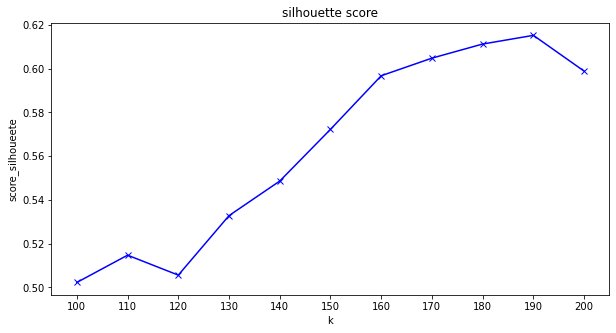

In [253]:
plt.figure(figsize=(10, 5))
plt.plot(K, score_silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('score_silhoueete')
plt.xticks(K)
plt.title('silhouette score')
plt.show()

In [254]:
# Usamos como cluster k = 190
k = 190
kmeans = MiniBatchKMeans(n_clusters=k, random_state=12, init='k-means++', batch_size=100, n_init=3)
kmeans = kmeans.fit(matrix)
labels = kmeans.labels_

In [255]:
labels

array([ 72,  87, 105, ..., 130, 148, 128], dtype=int32)

In [256]:
len(labels)

19986

In [257]:
df['labels'] = labels

In [258]:
df.labels.value_counts()

8      831
42     601
1      538
36     499
9      474
      ... 
69      15
178     14
94      11
144     10
19       8
Name: labels, Length: 186, dtype: int64

In [259]:
# Guardamos las películas con sus respectivas etiquetas
df.to_csv('./data/movies_with_labels.csv', header=True, index=False)

In [260]:
def get_label(text):
    
    
    y = tfidf.transform([text])
    
    label_pred = kmeans.predict(y)
    
    return label_pred

l = get_label('drama sci-fi current known adventure')

In [261]:
l[0]

70

In [262]:
def get_df_films(label, film):

    return df[((df['labels'] == label) | (df['title'] == film))].copy()

films = get_df_films(l[0], 'Interstellar')

In [263]:
films.head(5)

,id,title,genre,country,epoch,duration,known,description,documents,labels
255,tt0027623,Flash Gordon,"Action, Adventure, Sci-Fi",USA,classic,long,unknown,"Flash Gordon, Dale Arden and Dr. Alexis Zarkov...",action adventure sci-fi classic unknown,70
1242,tt0049223,Forbidden Planet,"Action, Adventure, Sci-Fi","USA, Japan",classic,normal,known,A starship crew goes to investigate the silenc...,action adventure sci-fi classic known,70
1513,tt0053464,Yûsei ôji,"Action, Adventure, Sci-Fi",Japan,classic,normal,unknown,When an alien force tries to invade Earth to s...,action adventure sci-fi classic unknown,70
1645,tt0055294,The Phantom Planet,"Action, Adventure, Sci-Fi",USA,classic,short,unknown,After an invisible asteroid draws an astronaut...,action adventure sci-fi classic unknown,70
1663,tt0055608,Voyage to the Bottom of the Sea,"Action, Adventure, Sci-Fi",USA,classic,normal,unknown,When the Earth is threatened by a burning Van ...,action adventure sci-fi classic unknown,70


In [264]:
films = films.reset_index()
films = films.drop_duplicates(subset=['title'], keep='last')
films.shape

(190, 11)

In [265]:
def get_recommendation(dataframe, film):
    
    indice_movies = pd.Series(dataframe.index, index=dataframe['title'])

    tfidf2 = TfidfVectorizer(stop_words='english')
    matrix_tfidf = tfidf.fit_transform(dataframe['documents'])

    cos_sim = cosine_similarity(matrix_tfidf, matrix_tfidf)

    scores = sorted(list(enumerate(cos_sim[indice_movies[film]])), key=lambda l: l[1], reverse=True)

    movie_indices = [f[0] for f in scores[:10]]

    return dataframe['title'].iloc[movie_indices]

In [266]:
 r = get_recommendation(films, 'Interstellar')

In [267]:
r.reset_index().drop('index', axis=1)

,title
0,Star Trek VI: The Undiscovered Country
1,Jurassic Park
2,Stargate
3,Waterworld
4,Escape from L.A.
5,Independence Day
6,The Fifth Element
7,The Lost World: Jurassic Park
8,Starship Troopers
9,Armageddon


In [268]:
!ls Models

kmeans-films.joblib


In [269]:
dump(kmeans, './Models/kmeans-films.joblib')

['./Models/kmeans-films.joblib']